In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import seaborn as sns

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

pd.pandas.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_colwidth', 120)
import pickle
import warnings
warnings.simplefilter(action='ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold, ParameterGrid
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost.sklearn import XGBClassifier
from mlxtend.classifier import EnsembleVoteClassifier, StackingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

In [2]:
project_path = r'C:\Users\kchanas\Documents\Learning\Kaggle\Titanic'
X_train = pd.read_csv(os.path.join(project_path, r'data\X_train.csv'), index_col=0)
y_train = pd.read_csv(os.path.join(project_path, r'data\y_train.csv'), index_col=0, names=['Survived'], header=0)
X_test = pd.read_csv(os.path.join(project_path, r'data\X_test.csv'), index_col=0)
y_test = pd.read_csv(os.path.join(project_path, r'data\y_test.csv'), index_col=0, names=['Survived'], header=0)

In [3]:
with open(os.path.join(project_path, r'data\svc_selected_features.txt'), "rb") as f:
      svc_selected_features = pickle.load(f)

with open(os.path.join(project_path, r'data\lr_selected_features.txt'), "rb") as f:
      lr_selected_features = pickle.load(f)

with open(os.path.join(project_path, r'data\kn_selected_features.txt'), "rb") as f:
      kn_selected_features = pickle.load(f)
        
with open(os.path.join(project_path, r'data\rf_selected_features.txt'), "rb") as f:
      rf_selected_features = pickle.load(f)
        
with open(os.path.join(project_path, r'data\xgb_selected_features.txt'), "rb") as f:
      xgb_selected_features = pickle.load(f)
        

In [4]:
svc_selected_features_idx = [X_train.columns.get_loc(c) for c in svc_selected_features if c in X_train]
lr_selected_features_idx = [X_train.columns.get_loc(c) for c in lr_selected_features if c in X_train]
kn_selected_features_idx = [X_train.columns.get_loc(c) for c in kn_selected_features if c in X_train]
rf_selected_features_idx = [X_train.columns.get_loc(c) for c in rf_selected_features if c in X_train]
xgb_selected_features_idx = [X_train.columns.get_loc(c) for c in xgb_selected_features if c in X_train]


In [5]:
pca = PCA()
pca.fit(X_train.iloc[:,svc_selected_features_idx])
pca.explained_variance_ratio_.cumsum()

array([0.36164895, 0.57700526, 0.72945299, 0.85550045, 0.91732154,
       0.96909732, 0.98718585, 0.9938323 , 0.99864527, 1.        ])

In [6]:
pca = PCA()
pca.fit(X_train.iloc[:,lr_selected_features_idx])
pca.explained_variance_ratio_.cumsum()

array([0.37102192, 0.58646635, 0.71147399, 0.82377509, 0.91844232,
       0.96341191, 0.99120551, 1.        ])

In [7]:
pca = PCA()
pca.fit(X_train.iloc[:,kn_selected_features_idx])
pca.explained_variance_ratio_.cumsum()

array([0.36962884, 0.57660714, 0.72689218, 0.86785442, 0.98683184,
       1.        ])

In [8]:
pca = PCA()
pca.fit(X_train.iloc[:,rf_selected_features_idx])
pca.explained_variance_ratio_.cumsum()

array([0.36820617, 0.59889205, 0.77097319, 0.91327935, 0.97732968,
       0.99714414, 1.        ])

In [9]:
pca = PCA()
pca.fit(X_train.iloc[:,xgb_selected_features_idx])
pca.explained_variance_ratio_.cumsum()

array([0.40498849, 0.59145011, 0.72372238, 0.83038476, 0.89577926,
       0.94552267, 0.98314443, 0.9979021 , 1.        ])

In [10]:
class ItemsSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys: list):
        self.keys = keys

    def fit(self, x, y=None):
        return self

    def transform(self, dataframe):
        return np.array(dataframe)[:,self.keys]

## Training models

In [11]:
cv = KFold(n_splits=5, random_state=1)

In [12]:
pipe_svc = Pipeline([('select_items', ItemsSelector(keys=svc_selected_features_idx)),
                    ('pca', PCA()),
                   ('model', CalibratedClassifierCV(SVC(random_state=1, probability=True),cv=cv))
])


pipe_lr = Pipeline([('select_items', ItemsSelector(keys=kn_selected_features_idx)),
                    ('pca', PCA()),
                   ('model', CalibratedClassifierCV(LogisticRegression(random_state=1, max_iter=200),cv=cv))
])

pipe_kn = Pipeline([('select_items', ItemsSelector(keys=kn_selected_features_idx)),
                   ('pca', PCA()),
                   ('model', CalibratedClassifierCV(KNeighborsClassifier(),cv=cv))
])

pipe_rf = Pipeline([('select_items', ItemsSelector(keys=rf_selected_features_idx)),
                    ('pca', PCA()),
                       ('model', CalibratedClassifierCV(RandomForestClassifier(n_estimators=200, 
                                                                               oob_score=True, random_state=1),cv=cv))
])

pipe_xgb = Pipeline([('select_items', ItemsSelector(keys=xgb_selected_features_idx)),
                     ('pca', PCA()),
                       ('model', CalibratedClassifierCV(XGBClassifier(random_state=1, n_estimators=200),cv=cv))
])

In [13]:
grid_params_svc = {'pca__n_components': [0.6, 0.7, 0.8],
                   'model__base_estimator__C': [0.001, 0.01, 0.02, 0.05, 0.1, 0.3, 0.5, 0.7],
                   'model__base_estimator__kernel': ['linear','poly','rbf','sigmoid']}

grid_params_lr = {'pca__n_components': [0.6, 0.7, 0.8],
                  'model__base_estimator__C': [0.001, 0.01, 0.02, 0.05, 0.1, 0.3, 0.5, 0.7]
                 }

grid_params_kn = {'pca__n_components': [0.6, 0.7, 0.8],
                  'model__base_estimator__n_neighbors': [2, 5, 10, 15, 20, 30]
                 }

grid_params_rf = {'pca__n_components': [0.6, 0.7, 0.8],
                  'model__base_estimator__max_depth':[3, 5, 6, 7, 10, 12, 15, 20, 30] 
                 }

grid_params_xgb = {'pca__n_components': [0.6, 0.7, 0.8],
                   'model__base_estimator__learning_rate':[0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
                   'model__base_estimator__max_depth':[3, 5, 7, 10, 12, 15, 20, 25] 
                 }

In [14]:
models_names = ['SVC','LogisticRegression','KNeighbors', 'RandomForest', 'XGB']
models = [pipe_svc, pipe_lr, pipe_kn, pipe_rf, pipe_xgb]
grid_params = [grid_params_svc, grid_params_lr, grid_params_kn, grid_params_rf, grid_params_xgb]

In [15]:
thresholds = [n/20 for n in range(1,20)]

In [16]:
X_train.shape

(621, 28)

In [17]:
sm = SMOTE(sampling_strategy='auto', random_state=1)
X_train_cols = X_train.columns
X_train, y_train = sm.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns = X_train_cols)
y_train = pd.Series(y_train['Survived'])

In [18]:
X_train.shape

(768, 28)

In [19]:
models_res = []
for model_name, model, grid_param in zip(models_names, models, grid_params):
    params = ParameterGrid(grid_param)
    for param in params:
        model.set_params(**param)
        model.fit(X_train, y_train)
        y_probas = pd.DataFrame(model.predict_proba(X_test), index=X_test.index, columns = ['Prob_0','Prob_1'])
        train_y_probas = pd.DataFrame(model.predict_proba(X_train), index=X_train.index, columns = ['Prob_0','Prob_1'])
        auc = roc_auc_score(y_test, y_probas['Prob_1'])
        train_auc = roc_auc_score(y_train, train_y_probas['Prob_1']) 
        best_accuracy = 0
        best_train_accuracy = 0
        best_threshold = 0
        best_train_threshold = 0
        for threshold in thresholds:
            pred = np.where(y_probas['Prob_1']>=threshold, 1, 0)
            train_pred = np.where(train_y_probas['Prob_1']>=threshold, 1, 0)
            accuracy = accuracy_score(y_test, pred)
            train_accuracy = accuracy_score(y_train, train_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_threshold = threshold
            if train_accuracy > best_train_accuracy:
                best_train_accuracy = train_accuracy
                best_train_threshold = threshold
        models_res.append({'MODEL_NAME': model_name, 'PARAMS': param, 'AUC': auc, 'TRAIN_AUC': train_auc, 
                           'ACCURACY': best_accuracy, 'THRESHOLD': best_threshold, 'TRAIN_ACCURACY': best_train_accuracy,
                          'TRAIN_THRESHOLD': best_train_threshold})
models_res = pd.DataFrame(models_res)[['MODEL_NAME','PARAMS','AUC','TRAIN_AUC','ACCURACY','THRESHOLD',
                                      'TRAIN_ACCURACY','TRAIN_THRESHOLD']].sort_values('AUC',ascending=False).reset_index(drop=True)


In [20]:
models_res.head(20)

,MODEL_NAME,PARAMS,AUC,TRAIN_AUC,ACCURACY,THRESHOLD,TRAIN_ACCURACY,TRAIN_THRESHOLD
0,RandomForest,"{'model__base_estimator__max_depth': 20, 'pca__n_components': 0.6}",0.8690,0.9724,0.8321,0.7000,0.9180,0.5500
1,RandomForest,"{'model__base_estimator__max_depth': 15, 'pca__n_components': 0.6}",0.8690,0.9722,0.8321,0.7000,0.9180,0.5500
2,RandomForest,"{'model__base_estimator__max_depth': 30, 'pca__n_components': 0.6}",0.8687,0.9725,0.8321,0.7000,0.9180,0.5500
3,RandomForest,"{'model__base_estimator__max_depth': 12, 'pca__n_components': 0.6}",0.8673,0.9711,0.8321,0.7000,0.9180,0.5500
4,RandomForest,"{'model__base_estimator__max_depth': 10, 'pca__n_components': 0.6}",0.8667,0.9680,0.8284,0.6000,0.9102,0.5500
5,RandomForest,"{'model__base_estimator__max_depth': 6, 'pca__n_components': 0.6}",0.8615,0.9400,0.8172,0.7000,0.8672,0.6000
6,RandomForest,"{'model__base_estimator__max_depth': 10, 'pca__n_components': 0.8}",0.8614,0.9715,0.8246,0.6000,0.9180,0.5500
7,RandomForest,"{'model__base_estimator__max_depth': 7, 'pca__n_components': 0.6}",0.8610,0.9514,0.8209,0.7000,0.8841,0.5500
8,RandomForest,"{'model__base_estimator__max_depth': 10, 'pca__n_components': 0.7}",0.8610,0.9705,0.8321,0.6000,0.9154,0.5500
9,RandomForest,"{'model__base_estimator__max_depth': 12, 'pca__n_components': 0.7}",0.8606,0.9728,0.8321,0.6500,0.9193,0.5500


In [21]:
def plot_heatmap(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()

0, RandomForest, accuracy: 0.832


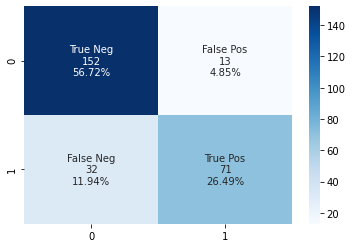

<Figure size 432x432 with 0 Axes>

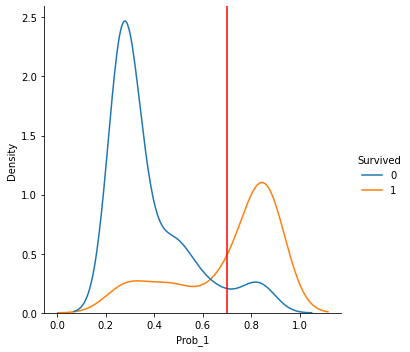

2, RandomForest, accuracy: 0.832


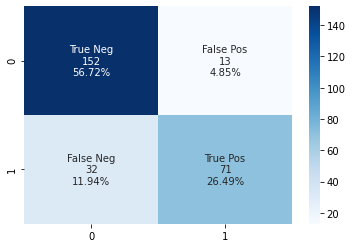

<Figure size 432x432 with 0 Axes>

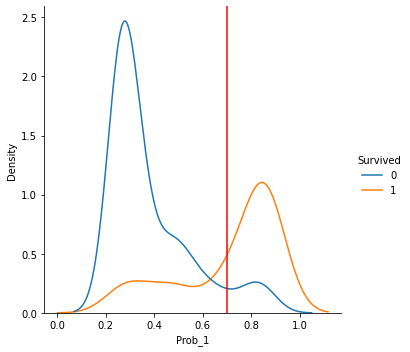

3, RandomForest, accuracy: 0.832


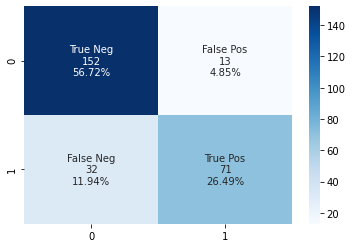

<Figure size 432x432 with 0 Axes>

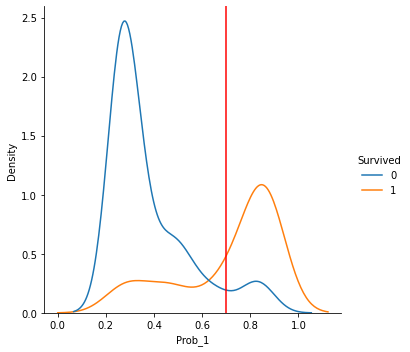

In [22]:
for idx, row in models_res.iloc[[0,2,3],:].iterrows():
    model_name = row['MODEL_NAME']
    models_idx = models_names.index(model_name)
    model = models[models_idx].set_params(**row['PARAMS'])
    model.fit(X_train, y_train)
    pred_proba = pd.DataFrame(model.predict_proba(X_test), index=X_test.index, columns = ['Prob_0','Prob_1'])
    pred = np.where(pred_proba['Prob_1'] > row['THRESHOLD'], 1, 0)
    accuracy = accuracy_score(y_test, pred)
    print(f"{idx}, {model_name}, accuracy: {accuracy:0.3f}")
    cf_matrix = confusion_matrix(y_test, pred)
    plot_heatmap(cf_matrix)
    plt.figure(figsize=(6,6))
    res = pd.concat([pred_proba['Prob_1'], y_test], axis=1)
    sns.displot(data=res, x='Prob_1', hue='Survived', kind='kde')
    plt.axvline(x=row['THRESHOLD'], color='r')
    plt.show()

## Ensembling models

In [23]:
models_to_vote = []

for idx, row in models_res.iloc[0:3,:].iterrows():
    model_name = row['MODEL_NAME']
    models_idx = models_names.index(model_name)
    model = models[models_idx].set_params(**row['PARAMS'])
    model.fit(X_train, y_train)
    models_to_vote.append(model)
    
vote = EnsembleVoteClassifier(clfs=models_to_vote, voting='soft')
grid_param = {'weights': [[1, 1, 1], [1, 1, 2], [2, 1, 1], [1, 2, 1]]}

voting_models_res = []
params = ParameterGrid(grid_param)
for param in params:
    vote.set_params(**param)
    vote.fit(X_train, y_train)
    y_probas = pd.DataFrame(vote.predict_proba(X_test), index=X_test.index, columns = ['Prob_0','Prob_1'])
    train_y_probas = pd.DataFrame(vote.predict_proba(X_train), index=X_train.index, columns = ['Prob_0','Prob_1'])
    auc = roc_auc_score(y_test, y_probas['Prob_1'])
    train_auc = roc_auc_score(y_train, train_y_probas['Prob_1']) 
    pred = np.where(y_probas['Prob_1']>=threshold, 1, 0)
    accuracy = accuracy_score(y_test, pred)
    best_accuracy = 0
    best_train_accuracy = 0
    best_treshold = 0
    best_train_threshold = 0
    for threshold in thresholds:
        pred = np.where(y_probas['Prob_1']>=threshold, 1, 0)
        train_pred = np.where(train_y_probas['Prob_1']>=threshold, 1, 0)
        accuracy = accuracy_score(y_test, pred)
        train_accuracy = accuracy_score(y_train, train_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
        if train_accuracy > best_train_accuracy:
            best_train_accuracy = train_accuracy
            best_train_threshold = threshold
    pred = [[p] for p in pred]
    voting_models_res.append({'MODEL_NAME': 'Voting', 'PARAMS': param, 'AUC': auc, 'TRAIN_AUC': train_auc, 
                           'ACCURACY': best_accuracy, 'THRESHOLD': best_threshold, 'TRAIN_ACCURACY': best_train_accuracy,
                          'TRAIN_THRESHOLD': best_train_threshold})
voting_models_res = pd.DataFrame(voting_models_res)[['MODEL_NAME','PARAMS','AUC','TRAIN_AUC','ACCURACY','THRESHOLD',
                                      'TRAIN_ACCURACY','TRAIN_THRESHOLD']].sort_values('AUC',ascending=False).reset_index(drop=True)


In [24]:
voting_models_res

,MODEL_NAME,PARAMS,AUC,TRAIN_AUC,ACCURACY,THRESHOLD,TRAIN_ACCURACY,TRAIN_THRESHOLD
0,Voting,"{'weights': [1, 1, 1]}",0.8687,0.9725,0.8321,0.7000,0.9180,0.5500
1,Voting,"{'weights': [1, 1, 2]}",0.8687,0.9725,0.8321,0.7000,0.9180,0.5500
2,Voting,"{'weights': [2, 1, 1]}",0.8687,0.9725,0.8321,0.7000,0.9180,0.5500
3,Voting,"{'weights': [1, 2, 1]}",0.8687,0.9725,0.8321,0.7000,0.9180,0.5500


0.7
'Voting', accuracy: 0.832


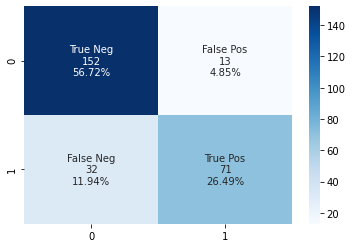

<Figure size 432x432 with 0 Axes>

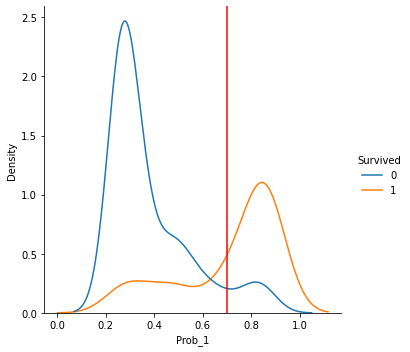

In [25]:
vote.set_params(**voting_models_res['PARAMS'].loc[0])
vote.fit(X_train, y_train)

pred_proba = pd.DataFrame(vote.predict_proba(X_test), index=X_test.index, columns = ['Prob_0','Prob_1'])
print(models_res['THRESHOLD'].loc[0])
pred = pd.Series(np.where(pred_proba['Prob_1']>=models_res['THRESHOLD'].loc[0], 1, 0), name='Prediction', index=y_test.index)
accuracy = accuracy_score(y_test, pred)
print(f"'Voting', accuracy: {accuracy:0.3f}")
cf_matrix = confusion_matrix(y_test, pred)
plot_heatmap(cf_matrix)
plt.figure(figsize=(6,6))
res = pd.concat([pred_proba['Prob_1'], y_test], axis=1)
sns.displot(data=res, x='Prob_1', hue='Survived', kind='kde')
plt.axvline(x=row['THRESHOLD'], color='r')
plt.show()

## Stacking Models

In [26]:
StackingClassifier??

In [27]:
models_to_stack = []

for idx, row in models_res.iloc[[0,5,9],:].iterrows():
    model_name = row['MODEL_NAME']
    models_idx = models_names.index(model_name)
    model = models[models_idx].set_params(**row['PARAMS'])
    model.fit(X_train, y_train)
    models_to_stack.append(model)
    
stack = StackingClassifier(classifiers=models_to_stack, meta_classifier=LogisticRegression(), fit_base_estimators=False, use_probas=True,
                          average_probas=False, use_features_in_secondary=True, drop_proba_col='first')
grid_param = {'meta_classifier__C': [0.001, 0.01, 0.02, 0.05, 0.1, 0.3, 0.5, 0.7]}

stacking_models_res = []
params = ParameterGrid(grid_param)
for param in params:
    stack.set_params(**param)
    stack.fit(X_train, y_train)
    y_probas = pd.DataFrame(stack.predict_proba(X_test), index=X_test.index, columns = ['Prob_0','Prob_1'])
    train_y_probas = pd.DataFrame(stack.predict_proba(X_train), index=X_train.index, columns = ['Prob_0','Prob_1'])
    auc = roc_auc_score(y_test, y_probas['Prob_1'])
    train_auc = roc_auc_score(y_train, train_y_probas['Prob_1']) 
    pred = np.where(y_probas['Prob_1']>=threshold, 1, 0)
    accuracy = accuracy_score(y_test, pred)
    best_accuracy = 0
    best_train_accuracy = 0
    best_treshold = 0
    best_train_threshold = 0
    for threshold in thresholds:
        pred = np.where(y_probas['Prob_1']>=threshold, 1, 0)
        train_pred = np.where(train_y_probas['Prob_1']>=threshold, 1, 0)
        accuracy = accuracy_score(y_test, pred)
        train_accuracy = accuracy_score(y_train, train_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
        if train_accuracy > best_train_accuracy:
            best_train_accuracy = train_accuracy
            best_train_threshold = threshold
    pred = [[p] for p in pred]
    stacking_models_res.append({'MODEL_NAME': 'stacking', 'PARAMS': param, 'AUC': auc, 'TRAIN_AUC': train_auc, 
                           'ACCURACY': best_accuracy, 'THRESHOLD': best_threshold, 'TRAIN_ACCURACY': best_train_accuracy,
                          'TRAIN_THRESHOLD': best_train_threshold})
stacking_models_res = pd.DataFrame(stacking_models_res)[['MODEL_NAME','PARAMS','AUC','TRAIN_AUC','ACCURACY','THRESHOLD',
                                      'TRAIN_ACCURACY','TRAIN_THRESHOLD']].sort_values('AUC',ascending=False).reset_index(drop=True)

In [28]:
stacking_models_res

,MODEL_NAME,PARAMS,AUC,TRAIN_AUC,ACCURACY,THRESHOLD,TRAIN_ACCURACY,TRAIN_THRESHOLD
0,stacking,{'meta_classifier__C': 0.01},0.8727,0.9292,0.8246,0.5000,0.8581,0.6000
1,stacking,{'meta_classifier__C': 0.02},0.8721,0.9399,0.8284,0.5000,0.8698,0.5500
2,stacking,{'meta_classifier__C': 0.05},0.8669,0.9542,0.8358,0.5000,0.8932,0.5000
3,stacking,{'meta_classifier__C': 0.001},0.8645,0.9023,0.7985,0.5000,0.8346,0.5000
4,stacking,{'meta_classifier__C': 0.1},0.8617,0.9634,0.8321,0.7500,0.9115,0.5000
5,stacking,{'meta_classifier__C': 0.3},0.8569,0.9715,0.8321,0.6500,0.9219,0.4500
6,stacking,{'meta_classifier__C': 0.5},0.8505,0.9739,0.8321,0.7000,0.9245,0.5000
7,stacking,{'meta_classifier__C': 0.7},0.8490,0.9748,0.8284,0.7000,0.9258,0.5000


0.7
'stacking', accuracy: 0.799


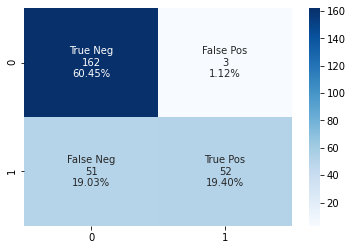

<Figure size 432x432 with 0 Axes>

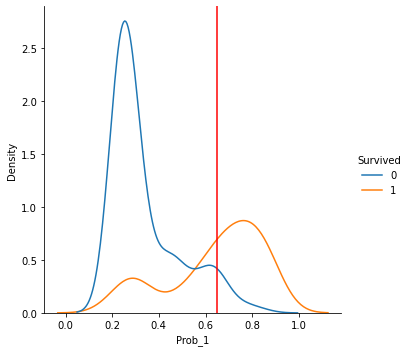

In [29]:
stack.set_params(**stacking_models_res['PARAMS'].loc[0])
stack.fit(X_train, y_train)
pred_proba = pd.DataFrame(stack.predict_proba(X_test), index=X_test.index, columns = ['Prob_0','Prob_1'])
print(models_res['THRESHOLD'].loc[0])
pred = pd.Series(np.where(pred_proba['Prob_1']>=models_res['THRESHOLD'].loc[0], 1, 0), name='Prediction', index=y_test.index)
accuracy = accuracy_score(y_test, pred)
print(f"'stacking', accuracy: {accuracy:0.3f}")
cf_matrix = confusion_matrix(y_test, pred)
plot_heatmap(cf_matrix)
plt.figure(figsize=(6,6))
res = pd.concat([pred_proba['Prob_1'], y_test], axis=1)
sns.displot(data=res, x='Prob_1', hue='Survived', kind='kde')
plt.axvline(x=row['THRESHOLD'], color='r')
plt.show()

## Saving submission

In [30]:
test = pd.read_csv(os.path.join(project_path, r'data\test_lb.csv')).set_index('PassengerId')

proba_lb = pd.DataFrame(stack.predict_proba(test), index=test.index, columns = ['Prob_0','Prob_1'])
pred_lb = np.where(proba_lb['Prob_1']>=models_res['THRESHOLD'].loc[0], 1, 0)
pred_lb = pd.DataFrame(pred_lb, columns = ['Survived'], index=test.index).reset_index()
pred_lb.to_csv(os.path.join(project_path, r'data\submission.csv'),index=False)

In [31]:
pred_lb['Survived'].sum()

86

## Model errors analysis

In [32]:
data = pd.read_csv(os.path.join(project_path, r'sandbox\X_test_before_encoding.csv'), index_col=0)
data.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title,Ticket_Type,Cabin_Type,Age_Bucket,Fare_Bucket,SibSp_Bucket,Parch_Bucket
PassengerId,,,,,,,,,,,,,,
434,0,3,male,0,0,2.0949,S,Mr.,Other,NoCabin,0-19,0-11,0,0
222,0,2,male,0,0,2.6391,S,Mr.,6-digit,NoCabin,25-32,11-46,0,0
218,0,2,male,1,0,3.3322,S,Mr.,6-digit,NoCabin,32-42,11-46,1,0
377,1,3,female,0,0,2.1102,S,Miss.,Other,NoCabin,19-25,0-11,0,0
448,1,1,male,0,0,3.3160,S,Mr.,6-digit,NoCabin,32-42,11-46,0,0


In [33]:
data = pd.concat([data, pred_proba, pred], axis=1)
data

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title,Ticket_Type,Cabin_Type,Age_Bucket,Fare_Bucket,SibSp_Bucket,Parch_Bucket,Prob_0,Prob_1,Prediction
434,0,3,male,0,0,2.0949,S,Mr.,Other,NoCabin,0-19,0-11,0,0,0.7455,0.2545,0
222,0,2,male,0,0,2.6391,S,Mr.,6-digit,NoCabin,25-32,11-46,0,0,0.7297,0.2703,0
218,0,2,male,1,0,3.3322,S,Mr.,6-digit,NoCabin,32-42,11-46,1,0,0.7200,0.2800,0
377,1,3,female,0,0,2.1102,S,Miss.,Other,NoCabin,19-25,0-11,0,0,0.4704,0.5296,0
448,1,1,male,0,0,3.3160,S,Mr.,6-digit,NoCabin,32-42,11-46,0,0,0.4810,0.5190,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,0,3,male,1,0,2.8391,S,Mr.,6-digit,NoCabin,Missing,11-46,1,0,0.7671,0.2329,0
771,0,3,male,0,0,2.3514,S,Mr.,6-digit,NoCabin,19-25,0-11,0,0,0.7870,0.2130,0
851,0,3,male,4,2,3.4743,S,Master.,6-digit,NoCabin,0-19,11-46,2>=,2>=,0.6848,0.3152,0
229,0,2,male,0,0,2.6391,S,Mr.,6-digit,NoCabin,0-19,11-46,0,0,0.7160,0.2840,0


In [34]:
data['Result'] = ''
data['Result'] = np.where((data['Prediction']==0) & (data['Survived']==0), 'TN', data['Result'])
data['Result'] = np.where((data['Prediction']==1) & (data['Survived']==1), 'TP', data['Result'])
data['Result'] = np.where((data['Prediction']==0) & (data['Survived']==1), 'FN', data['Result'])
data['Result'] = np.where((data['Prediction']==1) & (data['Survived']==0), 'FP', data['Result'])
data['Result'].value_counts()

TN    162
TP     52
FN     51
FP      3
Name: Result, dtype: int64

In [35]:
data.columns

Index(['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'Title', 'Ticket_Type', 'Cabin_Type', 'Age_Bucket', 'Fare_Bucket',
       'SibSp_Bucket', 'Parch_Bucket', 'Prob_0', 'Prob_1', 'Prediction',
       'Result'],
      dtype='object')

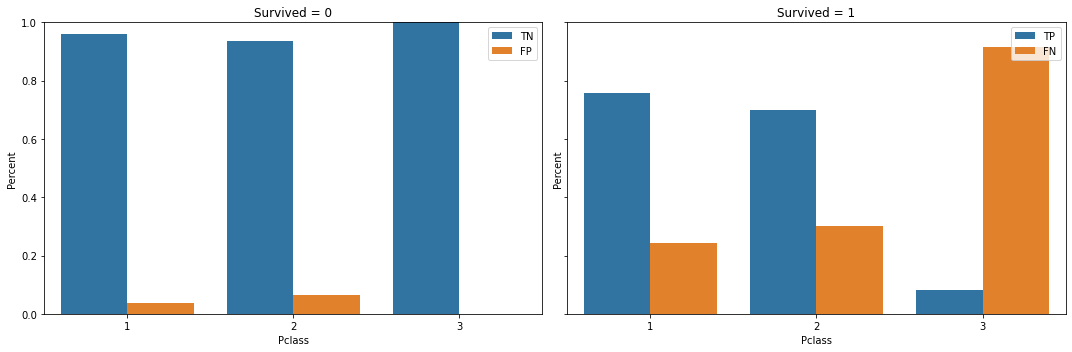

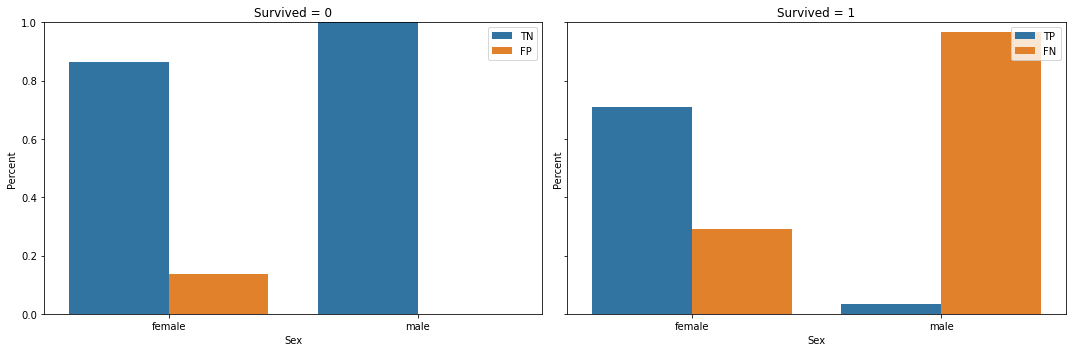

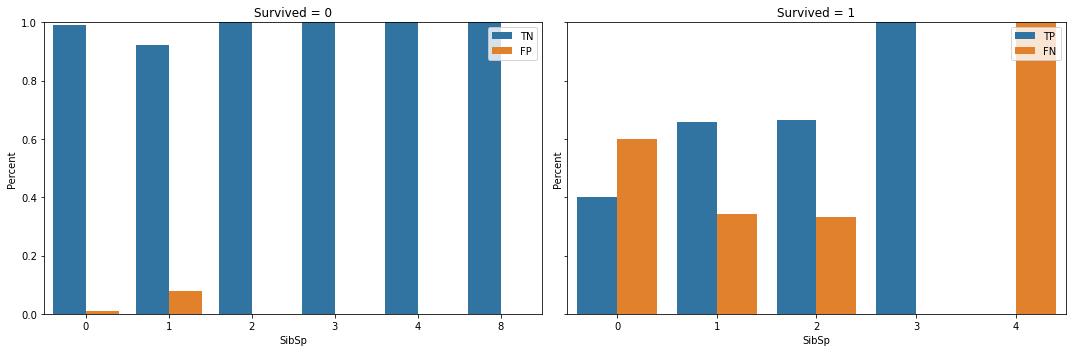

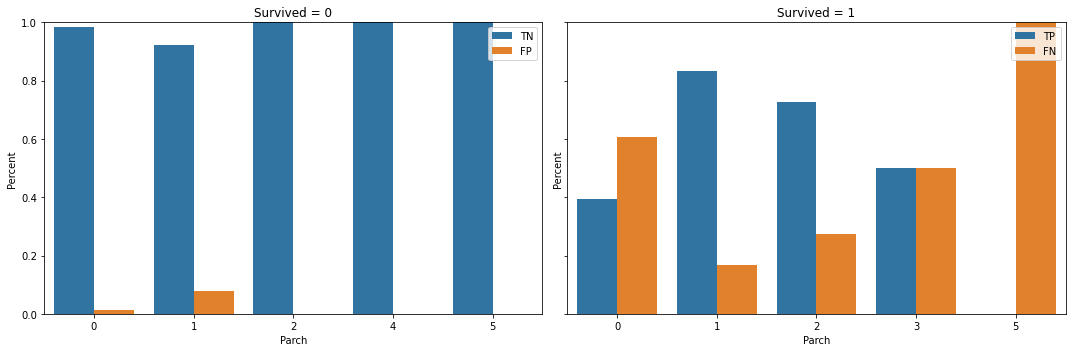

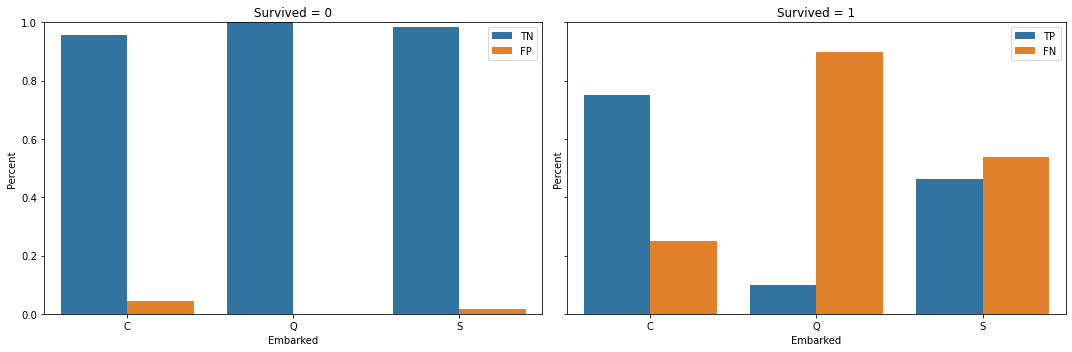

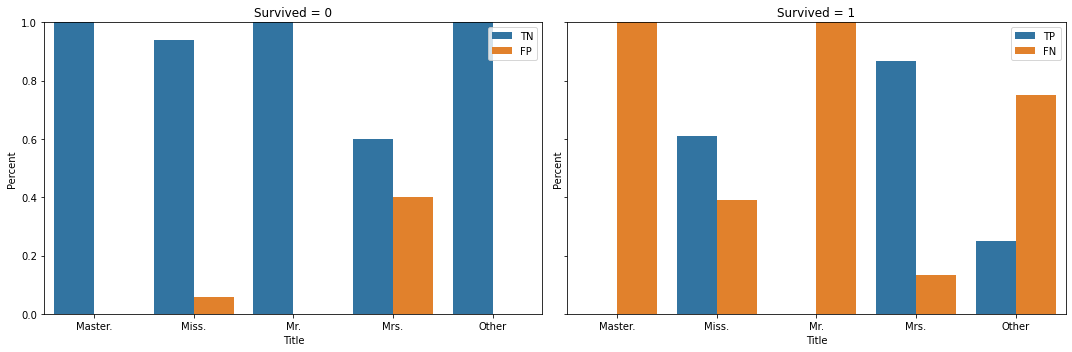

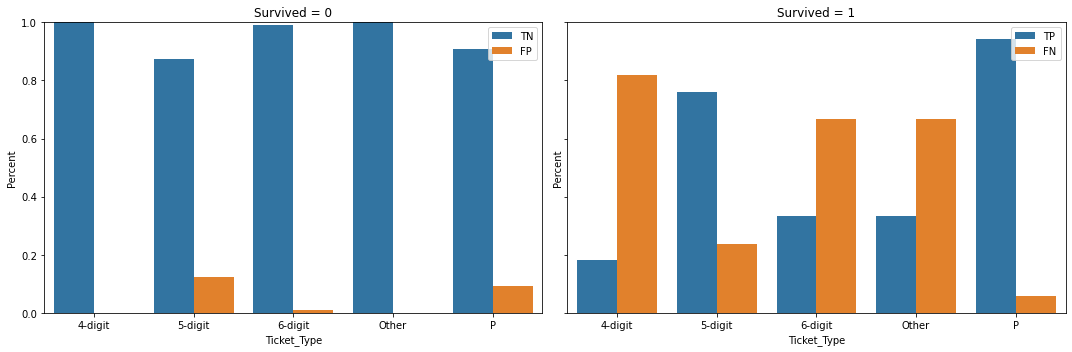

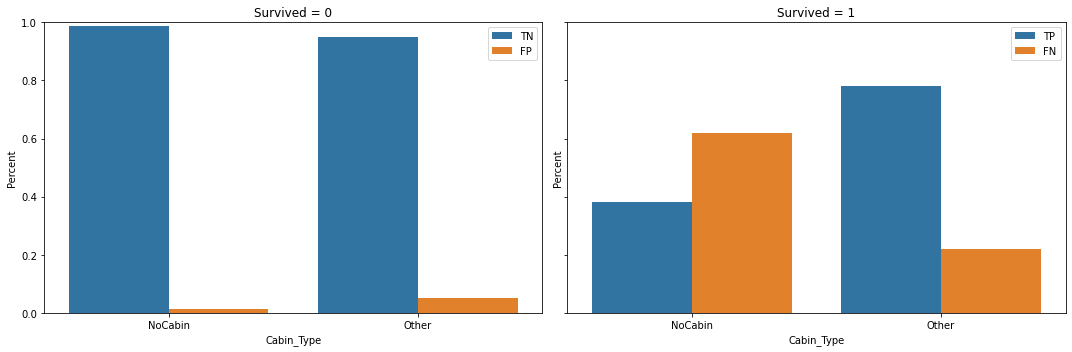

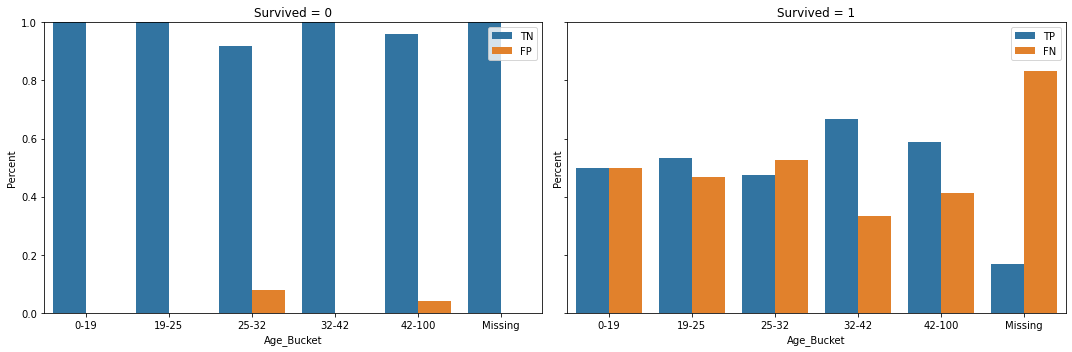

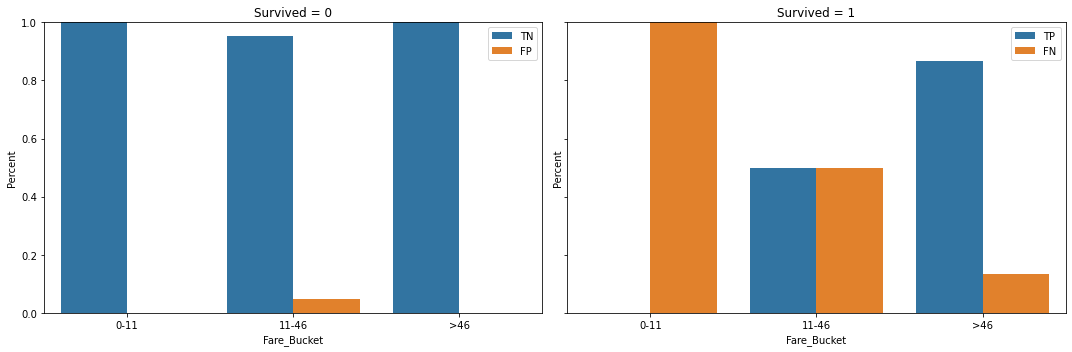

In [36]:
survived = data['Survived'].unique()

def plot_error_analysis(var):
    res = data.groupby(['Survived',var])['Result'].value_counts(normalize=True).rename('Percent').reset_index()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
    for s, ax, hue_order in zip(survived, [ax1, ax2], [['TN','FP'], ['TP','FN']]):
        sns.barplot(data=res[res['Survived']==s], x=var, y='Percent', hue='Result', hue_order=hue_order, ax=ax)
        ax.set_ylim(0,1)
        ax.set_title(label=f'Survived = {s}')
        ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
for var in ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title',
       'Ticket_Type', 'Cabin_Type', 'Age_Bucket', 'Fare_Bucket']:
    plot_error_analysis(var)